In [45]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

from skimage import color
from skimage import io
from scipy import stats
from skimage.feature import graycomatrix, graycoprops

import pandas as pd
import seaborn as sns

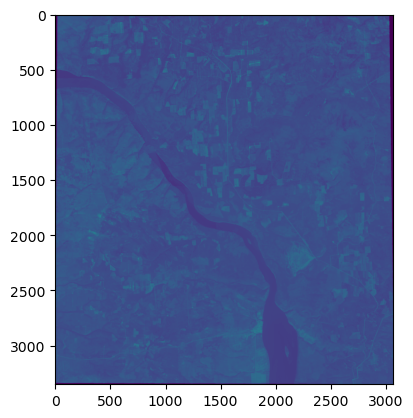

In [2]:
#downloading and preparing satellite image

#path to Sentinell-2 L2A tiff file 
fname='../rasters/bands_and_terrain.tiff'

img = rasterio.open(fname)

red = img.read(4)
green = img.read(3)
blue = img.read(2)
nir = img.read(8)

def normalize(band):
    band[np.isnan(band)] = 0.
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def remove_zero_pad(image):
    dummy = np.argwhere(image != 0) # assume blackground is zero
    max_y = dummy[:, 0].max()
    min_y = dummy[:, 0].min()
    min_x = dummy[:, 1].min()
    max_x = dummy[:, 1].max()
    crop_image = image[min_y:max_y, min_x:max_x]

    return crop_image

red_b=normalize(remove_zero_pad(red))
blue_b=normalize(remove_zero_pad(blue))
green_b=normalize(remove_zero_pad(green))
nir_b=normalize(remove_zero_pad(nir))

rgb_composite= np.dstack((red_b, green_b, blue_b))
img_grayscale = color.rgb2gray(rgb_composite)
img_grayscale[img_grayscale==0.] = 0.03


plt.imshow(img_grayscale)

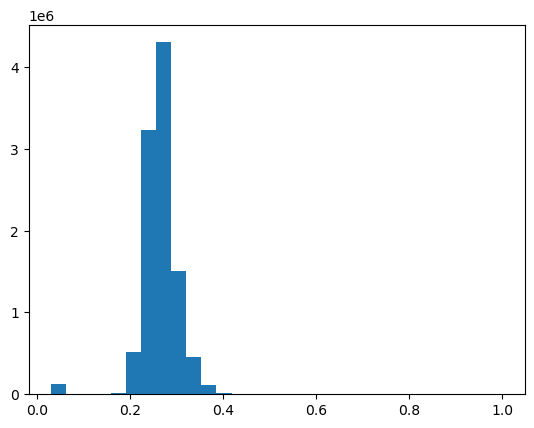

In [5]:
plt.hist(img_grayscale.flatten(), bins=30);

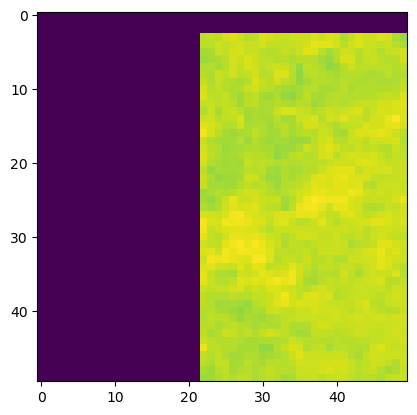

In [4]:
plt.imshow(img_grayscale[0:50,0:50])

In [40]:
def offset(length, angle):
    """Return the offset in pixels for a given length and angle"""
    dv = length * np.sign(-np.sin(angle)).astype(np.int32)
    dh = length * np.sign(np.cos(angle)).astype(np.int32)
    return dv, dh

def crop(img, center, win):
    """Return a square crop of img centered at center (side = 2*win + 1)"""
    row, col = center
    side = 2*win + 1
    first_row = row - win
    first_col = col - win
    last_row = first_row + side    
    last_col = first_col + side
    return img[first_row: last_row, first_col: last_col]

def cooc_maps(img, center, win, d=[1], theta=[0], levels=256):
    """
    Return a set of co-occurrence maps for different d and theta in a square 
    crop centered at center (side = 2*w + 1)
    """
    shape = (2*win + 1, 2*win + 1, len(d), len(theta))
    cooc = np.zeros(shape=shape, dtype=np.int32)
    row, col = center
    Ii = crop(img, (row, col), win)
    for d_index, length in enumerate(d):
        for a_index, angle in enumerate(theta):
            dv, dh = offset(length, angle)
            Ij = crop(img, center=(row + dv, col + dh), win=win)
            cooc[:, :, d_index, a_index] = encode_cooccurrence(Ii, Ij, levels)
    return cooc

def encode_cooccurrence(x, y, levels=256):
    """Return the code corresponding to co-occurrence of intensities x and y"""
    return x*levels + y

def decode_cooccurrence(code, levels=256):
    """Return the intensities x, y corresponding to code"""
    return code//levels, np.mod(code, levels)    

def compute_glcms(cooccurrence_maps, levels=256):
    """Compute the cooccurrence frequencies of the cooccurrence maps"""
    Nr, Na = cooccurrence_maps.shape[2:]
    glcms = np.zeros(shape=(levels, levels, Nr, Na), dtype=np.float64)
    for r in range(Nr):
        for a in range(Na):
            table = np.unique(cooccurrence_maps[:, :, r, a], return_counts=True)
            codes = table[0]
            freqs = table[1]/float(table[1].sum())
            i, j = decode_cooccurrence(codes, levels=levels)
            glcms[i, j, r, a] = freqs
    return glcms

def compute_props(glcms, props=('contrast',)):
    """Return a feature vector corresponding to a set of GLCM"""
    Nr, Na = glcms.shape[2:]
    features = np.zeros(shape=(Nr, Na, len(props)))
    for index, prop_name in enumerate(props):
        features[:, :, index] = graycoprops(glcms, prop_name)
    return features.ravel()

def haralick_features(img, win, d, theta, levels, props):
    """Return a map of Haralick features (one feature vector per pixel)"""
    rows, cols = img.shape
    margin = win + max(d)
    arr = np.pad(img, margin, mode='reflect')
    n_features = len(d) * len(theta) * len(props)
    feature_map = np.zeros(shape=(rows, cols, n_features), dtype=np.float64)
    for m in range(rows):
        for n in range(cols):
            coocs = cooc_maps(arr, (m + margin, n + margin), win, d, theta, levels)
            glcms = compute_glcms(coocs, levels)
            feature_map[m, n, :] = compute_props(glcms, props)
            count = (m*n)+n
            np.save('status', np.asarray((count/(rows*cols))*100)) 
    return feature_map


In [41]:
#hyperparameters for Haralick features computation
d = (1, 2)
theta = [0]
props = ('contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation')
levels = 256
win = 6

In [89]:
#cropping test patch from satellite image
test_patch = img_grayscale[0:50,0:50].copy()
test_patch.shape

(50, 50)

In [90]:
#Haralick features computation
feature_map = haralick_features(test_patch, win, d, theta, levels, props)

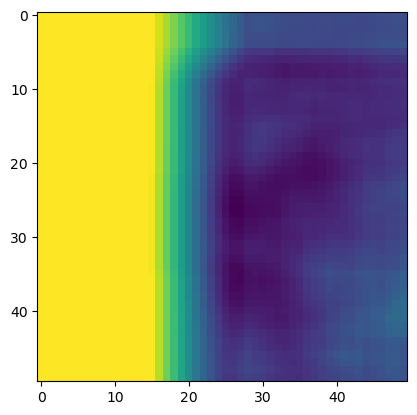

In [94]:
plt.imshow(feature_map[...,4])

### Correlated features

In [99]:
feature_map_r = feature_map.reshape((feature_map.shape[0]*feature_map.shape[1], 12))
feature_map_r.shape

(2500, 12)

In [101]:
feature_map_df = pd.DataFrame(feature_map_r)

In [102]:
feature_map_df = feature_map_df.drop(columns = [5,11])

In [53]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(fm)

AttributeError: 'numpy.ndarray' object has no attribute 'corr'